In [2]:
# 23/02/2022
# Francisco Domínguez Mateos
# from: https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

In [3]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2022-02-23 09:51:45--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2,1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2,13K  --.-KB/s    in 0s      

2022-02-23 09:51:46 (17,0 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

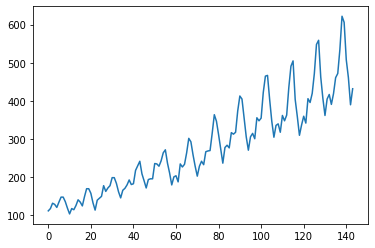

In [5]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

In [11]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
print(dataX.shape)
print(dataY.shape)

torch.Size([139, 4, 1])
torch.Size([139, 1])


In [7]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

In [8]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    # Forward step
    outputs = lstm(trainX)
    # Optimizing - backward step
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.28011
Epoch: 100, loss: 0.01816
Epoch: 200, loss: 0.01500
Epoch: 300, loss: 0.00356
Epoch: 400, loss: 0.00324
Epoch: 500, loss: 0.00275
Epoch: 600, loss: 0.00212
Epoch: 700, loss: 0.00174
Epoch: 800, loss: 0.00170
Epoch: 900, loss: 0.00169
Epoch: 1000, loss: 0.00168
Epoch: 1100, loss: 0.00166
Epoch: 1200, loss: 0.00165
Epoch: 1300, loss: 0.00164
Epoch: 1400, loss: 0.00162
Epoch: 1500, loss: 0.00160
Epoch: 1600, loss: 0.00157
Epoch: 1700, loss: 0.00155
Epoch: 1800, loss: 0.00153
Epoch: 1900, loss: 0.00150


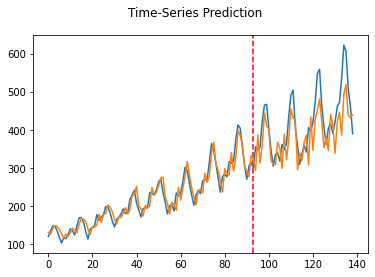

In [12]:
lstm.eval()
train_predict = lstm(dataX)

data_predict  = train_predict.data.numpy()
dataY_plot    = dataY.data.numpy()

data_predict  = sc.inverse_transform(data_predict)
dataY_plot    = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()